In [1]:
from google.colab import files
src = list(files.upload().values())

Saving utils.py to utils.py


In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from typing import Tuple, MutableSequence
import random
import math
from basic_units import radians
from utils import get_rad_ticks, generate_noise, get_samples, calc_time_between_transitions, set_up_plot, mark_bifurcation_points
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, LSTM, Input, Dropout, Embedding, TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers


# Generate data

## Common settings

In [3]:
series_len = 5000
random.seed(0)

## Without noise

### Graphs of the function and derivative

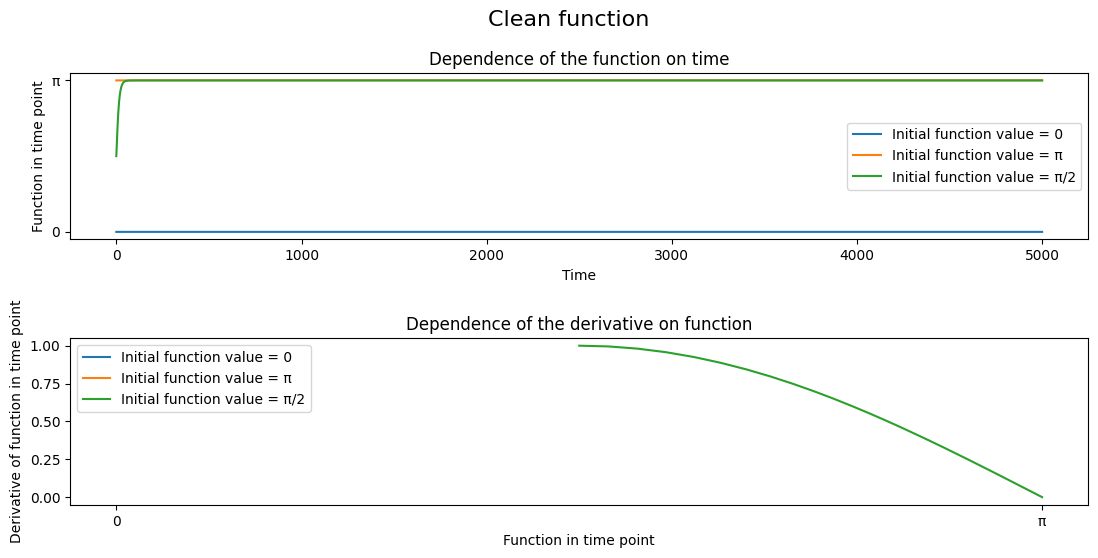

In [4]:
x_ts_0, d_ts_0 = get_samples(x_t_init = 0)
x_ts_pi, d_ts_pi = get_samples(x_t_init = math.pi)
x_ts_half_pi, d_ts_half_pi = get_samples(x_t_init = math.pi/2)

ax1, ax2 = set_up_plot('Clean function')

ax1.plot(x_ts_0, label='Initial function value = 0')
ax1.plot(x_ts_pi, label='Initial function value = π')
ax1.plot(x_ts_half_pi, label='Initial function value = π/2')
ax1.legend()

ax2.plot(x_ts_0, d_ts_0, label='Initial function value = 0')
ax2.plot(x_ts_pi, d_ts_pi, label='Initial function value = π')
ax2.plot(x_ts_half_pi, d_ts_half_pi, label='Initial function value = π/2')
ax2.legend()

### Distribution of transition points on delta t

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([-0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6]),
 <BarContainer object of 10 artists>)

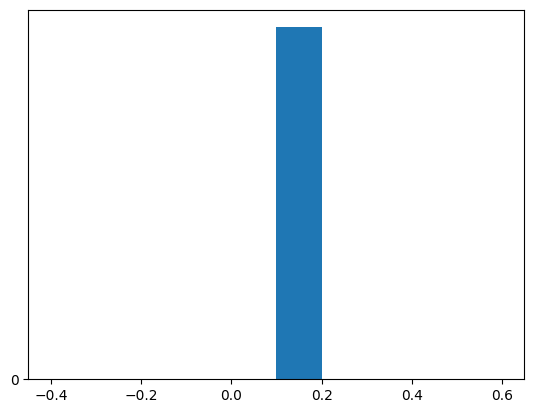

In [5]:
marked_data = calc_time_between_transitions(x_ts_half_pi)
plt.yticks(*get_rad_ticks(0, 1))
plt.hist(marked_data)

## White noise

### Graphs of the function and derivative

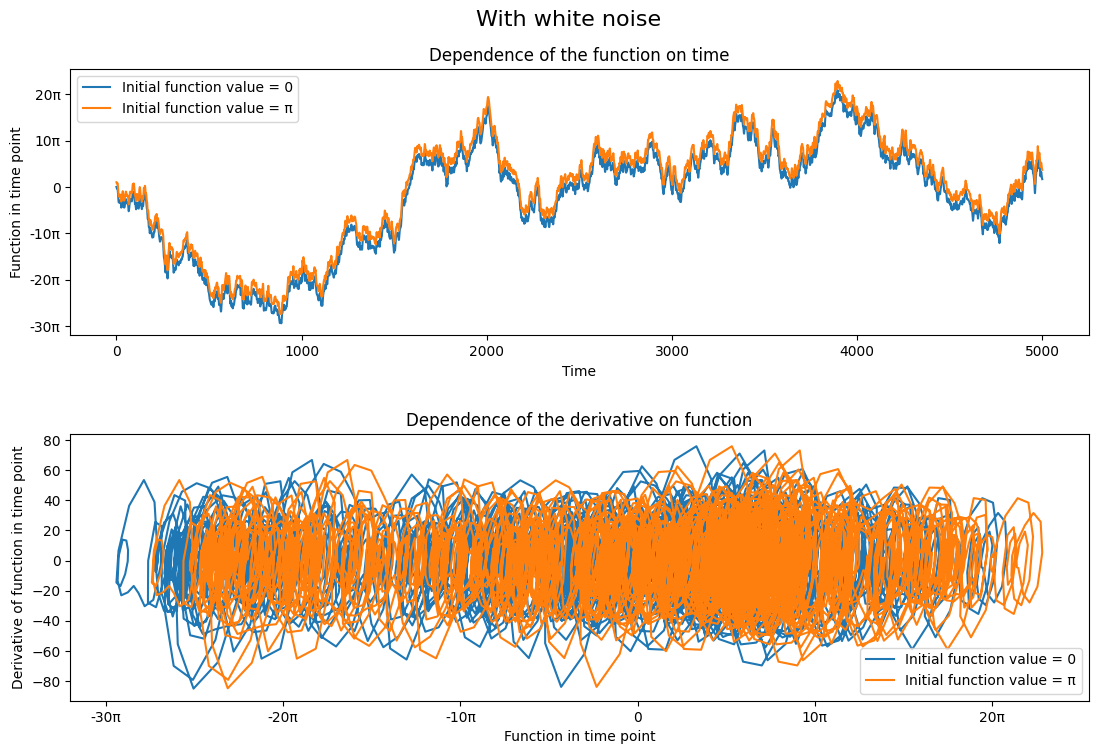

In [6]:
white_noise = generate_noise()
x_ts_0, d_ts_0 = get_samples(x_t_init = 0, noise=white_noise)
x_ts_pi, d_ts_pi = get_samples(x_t_init = math.pi, noise=white_noise)

ax1, ax2 = set_up_plot('With white noise', figsize=(12, 8), ticks_range=(-140, 120, 10))

ax1.plot(x_ts_0, label='Initial function value = 0')
ax1.plot(x_ts_pi, label='Initial function value = π')
ax1.legend()

ax2.plot(x_ts_0, d_ts_0, label='Initial function value = 0')
ax2.plot(x_ts_pi, d_ts_pi, label='Initial function value = π')
ax2.legend()

### Distribution of transition points on delta t

(array([916., 226., 141.,  58.,  30.,  16.,   8.,   9.,   1.,   1.]),
 array([0.1 , 0.31, 0.52, 0.73, 0.94, 1.15, 1.36, 1.57, 1.78, 1.99, 2.2 ]),
 <BarContainer object of 10 artists>)

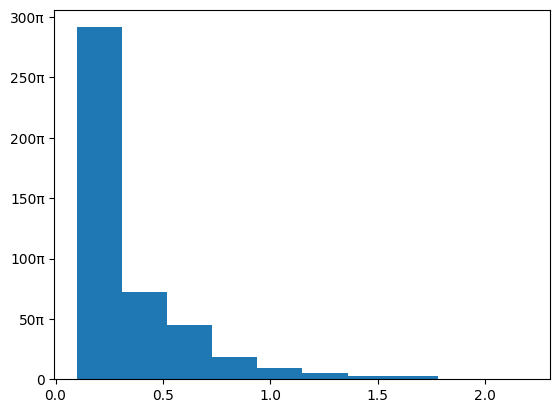

In [7]:
marked_data = calc_time_between_transitions(x_ts_0)
plt.yticks(*get_rad_ticks(0, 700, 50))
plt.hist(marked_data)

## Brown noise

### Graphs of the function and derivative

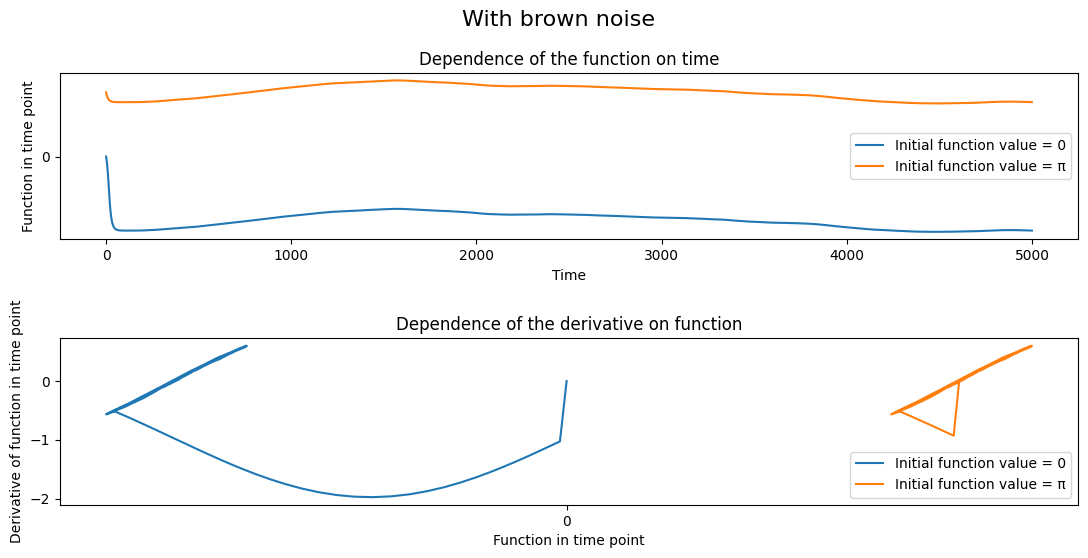

In [8]:
brown_noise = generate_noise(amplitude=lambda f: 1/f/f)
x_ts_0, d_ts_0 = get_samples(x_t_init = 0, noise=brown_noise)
x_ts_pi, d_ts_pi = get_samples(x_t_init = math.pi, noise=brown_noise)

ax1, ax2 = set_up_plot('With brown noise', figsize=(12, 6), ticks_range=(-10, 20, 2))

ax1.plot(x_ts_0, label='Initial function value = 0')
ax1.plot(x_ts_pi, label='Initial function value = π')
ax1.legend()

ax2.plot(x_ts_0, d_ts_0, label='Initial function value = 0')
ax2.plot(x_ts_pi, d_ts_pi, label='Initial function value = π')
ax2.legend()

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1]),
 <BarContainer object of 10 artists>)

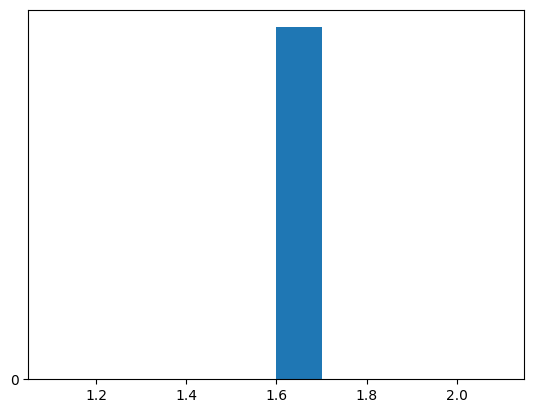

In [9]:
marked_data = calc_time_between_transitions(x_ts_0)
plt.yticks(*get_rad_ticks(0, 87))
plt.hist(marked_data)

### Distribution of transition points on delta t

## Blue noise

### Graphs of the function and derivative

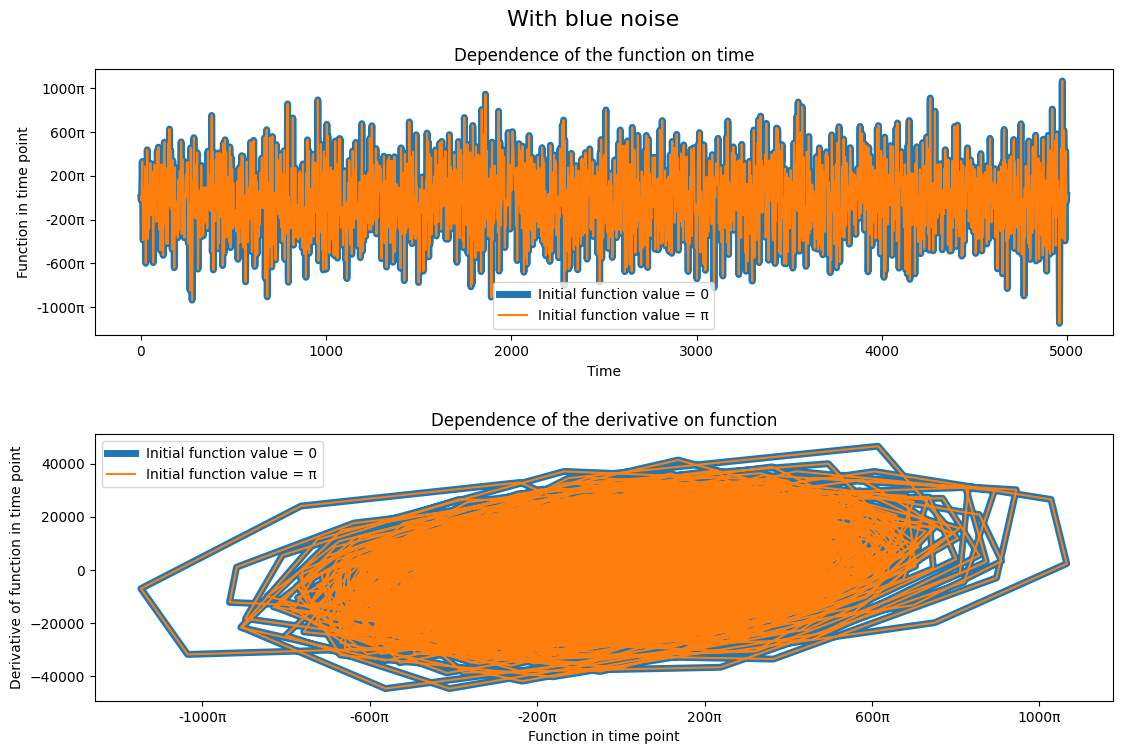

In [10]:
blue_noise = generate_noise(amplitude=lambda f: f)
x_ts_0, d_ts_0 = get_samples(x_t_init = 0, noise=blue_noise)
x_ts_pi, d_ts_pi = get_samples(x_t_init = math.pi, noise=blue_noise)

ax1, ax2 = set_up_plot('With blue noise', figsize=(12, 8), ticks_range=(-1800, 3000, 400))

ax1.plot(x_ts_0, label='Initial function value = 0', linewidth=5)
ax1.plot(x_ts_pi, label='Initial function value = π')
ax1.legend()

ax2.plot(x_ts_0, d_ts_0, label='Initial function value = 0', linewidth=5)
ax2.plot(x_ts_pi, d_ts_pi, label='Initial function value = π')
ax2.legend()

### Distribution of transition points on delta t

(array([4979.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          10.]),
 array([0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ]),
 <BarContainer object of 10 artists>)

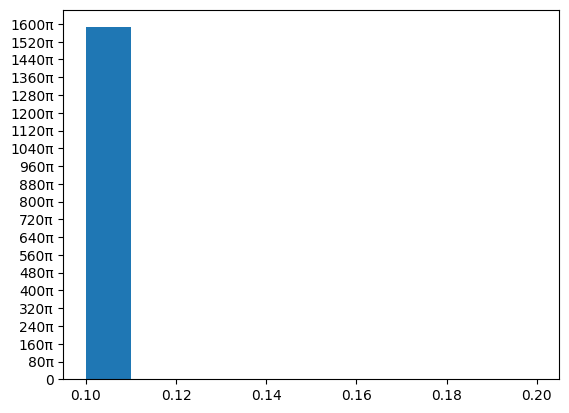

In [11]:
marked_data = calc_time_between_transitions(x_ts_0)
plt.yticks(*get_rad_ticks(0, 1800, 80))
plt.hist(marked_data)

# Data preprocessing

In [12]:
series_len = 100_000
noise = generate_noise(series_len)

x_ts, _ = get_samples(series_len, x_t_init = 0, noise=noise)

In [13]:
chunk_size = 10

In [14]:
X = np.array([x_ts[i:i + chunk_size] for i in range(len(x_ts) - chunk_size)])
X = X.reshape(X.shape[0], 1, chunk_size)
X.shape, X[:1]

((99990, 1, 10),
 array([[[ 0.        , -0.57676128, -1.18763967, -1.80436679,
          -2.39668473, -2.94681554, -3.45276818, -3.9235304 ,
          -4.37350707, -4.81911077]]]))

In [15]:
marked_data = mark_bifurcation_points(x_ts)
Y = np.array([marked_data[i:i + chunk_size] for i in range(len(marked_data) - chunk_size)])
Y = Y.reshape(Y.shape[0], 1, chunk_size)
Y.shape, Y[:1]

((99990, 1, 10), array([[[0., 0., 0., 1., 0., 0., 0., 0., 0., 1.]]]))

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, train_size=0.9)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((89991, 1, 10), (89991, 1, 10), (9999, 1, 10), (9999, 1, 10))

# Baseline

In [28]:
base_lstm = Sequential([
    LSTM(10, return_sequences=True, dropout=0.5, input_shape=(1, chunk_size)),
    TimeDistributed(Dense(chunk_size))
])

base_lstm.compile(loss='binary_crossentropy', metrics=['binary_accuracy'], optimizer='adam')

In [29]:
base_lstm.fit(X_train, y_train, batch_size=32, epochs=3, validation_data=(X_test, y_test))

Epoch 1/3
2813/2813 [==============================] - 17s 5ms/step - loss: 1.4585 - binary_accuracy: 0.6701 - val_loss: 0.8224 - val_binary_accuracy: 0.6704
Epoch 2/3
2813/2813 [==============================] - 16s 6ms/step - loss: 0.7796 - binary_accuracy: 0.6923 - val_loss: 0.6098 - val_binary_accuracy: 0.6978
Epoch 3/3
2813/2813 [==============================] - 12s 4ms/step - loss: 0.6395 - binary_accuracy: 0.7107 - val_loss: 0.5965 - val_binary_accuracy: 0.7176


In [19]:
pred = base_lstm.predict(X_test)
pred.shape

313/313 [==============================] - 3s 4ms/step


(9999, 1, 10)